In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from torchmetrics.functional import accuracy
from torchmetrics import F1Score
import lightning.pytorch as pl

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler , OneHotEncoder

In [3]:
bank_customer_churn_data = pd.read_csv("datasets/Churn_Modelling.csv")

bank_customer_churn_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,3,15619304,Onio,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,4,15701354,Boni,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43.0,2,125510.82,1,NaN,1.0,79084.10,0


In [5]:
bank_customer_churn_data.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [6]:
bank_customer_churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10002 entries, 0 to 10001
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10002 non-null  int64  
 1   CustomerId       10002 non-null  int64  
 2   Surname          10002 non-null  object 
 3   CreditScore      10002 non-null  int64  
 4   Geography        10001 non-null  object 
 5   Gender           10002 non-null  object 
 6   Age              10001 non-null  float64
 7   Tenure           10002 non-null  int64  
 8   Balance          10002 non-null  float64
 9   NumOfProducts    10002 non-null  int64  
 10  HasCrCard        10001 non-null  float64
 11  IsActiveMember   10001 non-null  float64
 12  EstimatedSalary  10002 non-null  float64
 13  Exited           10002 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 1.1+ MB


In [7]:
bank_customer_churn_data.dropna(inplace = True)

bank_customer_churn_data = bank_customer_churn_data.drop_duplicates()

bank_customer_churn_data.shape

(9996, 14)

In [8]:
bank_customer_churn_data["Exited"].value_counts()

Exited
0    7959
1    2037
Name: count, dtype: int64

<Axes: xlabel='Exited', ylabel='count'>

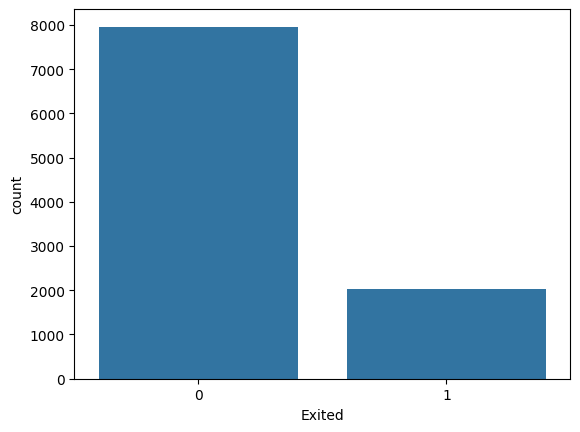

In [9]:
sns.countplot(data = bank_customer_churn_data  , x = "Exited")

In [27]:
from lightning.pytorch.utilities.types import TRAIN_DATALOADERS


class BankCustomerChurnDataModule(pl.LightningDataModule):
    def __init__(self, batchsize : int =8):
        super().__init__()
        self.batchsize = batchsize
        
    def prepare_data(self):
        self.bank_customer_churn_data = pd.read_csv("datasets/Churn_Modelling.csv")
        self.bank_customer_churn_data.dropna(inplace = True)
        self.bank_customer_churn_data = self.bank_customer_churn_data.drop_duplicates()
        
    def setup(self, stage = None):
        X = self.bank_customer_churn_data.drop(columns= ["Exited", "RowNumber", "CustomerId", "Surname"] , axis = 1)
        y = self.bank_customer_churn_data["Exited"]
        
        if stage == "fit" or stage is None:
            X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 123)
            
            categorical_features = ['Geography', 'Gender']

            categorical_transformer = OneHotEncoder(
                handle_unknown = 'ignore', drop = 'first', sparse_output = False
            )

            preprocessor = ColumnTransformer(
                transformers = [('cat_tr', categorical_transformer, categorical_features)],
                remainder='passthrough'
            )
            
            X_train = preprocessor.fit_transform(X_train)
            X_val = preprocessor.transform(X_val)
            
            y_train, y_val = np.array(y_train), np.array(y_val)
            
            scaler = StandardScaler()
            
            inputs_train_array = scaler.fit_transform(X_train)
            inputs_val_array = scaler.transform(X_val)
            
            self.train_inputs = torch.from_numpy(inputs_train_array).float()
            self.train_targets = torch.from_numpy(y_train.reshape(-1, 1)).float()
            self.val_inputs = torch.from_numpy(inputs_val_array).float()
            self.val_targets = torch.from_numpy(y_val.reshape(-1,1 )).float()
            
    
    def train_dataloader(self):
        train_dataset = TensorDataset(self.train_inputs, self.train_targets)
        train_loader = DataLoader(train_dataset, batch_size = self.batchsize, shuffle = True)
        return train_loader
    
    def val_dataloader(self):
        val_dataset = TensorDataset(self.val_inputs, self.val_targets)
        val_loader = DataLoader(val_dataset, batch_size = self.batchsize, shuffle = False)
        return val_loader
    
    
            

In [28]:
bank_customer_churn_dm = BankCustomerChurnDataModule()

In [29]:
bank_customer_churn_dm.prepare_data()
bank_customer_churn_dm.setup()

In [30]:
train_dl = bank_customer_churn_dm.train_dataloader()
next(iter(train_dl))

[tensor([[-5.7812e-01, -5.7465e-01,  9.0655e-01,  2.6679e-01, -9.4915e-01,
           6.9493e-01,  8.8880e-01, -9.1791e-01, -1.5547e+00, -1.0287e+00,
           1.5617e+00],
         [-5.7812e-01, -5.7465e-01, -1.1031e+00, -1.8033e+00, -6.6003e-01,
           1.0426e+00,  6.8199e-01, -9.1791e-01,  6.4321e-01, -1.0287e+00,
           1.8414e-02],
         [ 1.7297e+00, -5.7465e-01, -1.1031e+00, -7.1159e-01,  4.0005e-01,
          -3.9131e-04,  2.7012e-01,  2.5385e+00,  6.4321e-01, -1.0287e+00,
           7.2014e-01],
         [-5.7812e-01, -5.7465e-01, -1.1031e+00, -1.3913e+00, -1.3346e+00,
           6.9493e-01,  5.0854e-02, -9.1791e-01, -1.5547e+00,  9.7212e-01,
          -1.0641e+00],
         [-5.7812e-01, -5.7465e-01,  9.0655e-01,  1.2555e+00, -4.6729e-01,
           1.3902e+00, -1.2208e+00,  8.1028e-01,  6.4321e-01, -1.0287e+00,
           1.2426e+00],
         [-5.7812e-01, -5.7465e-01,  9.0655e-01,  6.8904e-01, -7.5640e-01,
          -3.4805e-01,  8.5303e-01, -9.1791e-01, -1.554

In [31]:
num_features =11

In [44]:
from typing import Any
from lightning.pytorch.utilities.types import STEP_OUTPUT, OptimizerLRScheduler


class LitBinaryClassificationModule(pl.LightningModule):
    def __init__(self, num_features : int = 11, lr : float = 0.001):
        super().__init__()
        self.layer_1 = nn.Linear(num_features, 16)
        self.layer_2 = nn.Linear(16, 8)
        self.layer_3 = nn.Linear(8, 4)
        self.layer_out = nn.Linear(4, 1)

        self.relu = nn.ReLU()
        self.save_hyperparameters()
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.layer_out(x)
        return x
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr = self.hparams.lr)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        X, y = batch
        logits = self(X)
        criterion = nn.BCEWithLogitsLoss()
        
        loss = criterion(logits, y)
        
        self.log("train_loss", loss, on_step = False, on_epoch = True, prog_bar = True)
        
        return loss
        
    
    def validation_step(self, batch, batch_idx):
        
        X, y = batch
        
        logits = self(X)
        
        criterion = nn.BCEWithLogitsLoss()
        
        loss = criterion(logits, y)
        
        preds = torch.round(torch.sigmoid(logits))
        
        acc= accuracy(preds, y, task= "binary")
        f1_score = F1Score(task= "binary")
        
        f1 = f1_score(preds, y)
        
        self.log(f"val_loss", loss, prog_bar = True)
        self.log(f"val_acc", acc, prog_bar = True)
        self.log(f"val_f1", f1, prog_bar = True)
        
    def predict_step(self, batch, batch_idx):
        X, y = batch
        logits = self(X)
        return logits
        
        

In [45]:
lit_clf_nn_model = LitBinaryClassificationModule(num_features = num_features) 

print(lit_clf_nn_model)

LitBinaryClassificationModule(
  (layer_1): Linear(in_features=11, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=8, bias=True)
  (layer_3): Linear(in_features=8, out_features=4, bias=True)
  (layer_out): Linear(in_features=4, out_features=1, bias=True)
  (relu): ReLU()
)


In [46]:
from pytorch_lightning.loggers import CSVLogger

bank_customer_churn_dm = BankCustomerChurnDataModule() 

logger = CSVLogger("logs", name = "pytorch_lightning_classification")

trainer = pl.Trainer(max_epochs = 20, logger = logger)

trainer.fit(lit_clf_nn_model , datamodule = bank_customer_churn_dm)                                   

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type   | Params
-------------------------------------
0 | layer_1   | Linear | 192   
1 | layer_2   | Linear | 136   
2 | layer_3   | Linear | 36    
3 | layer_out | Linear | 5     
4 | relu      | ReLU   | 0     
-------------------------------------
369       Trainable params
0         Non-trainable params
369       Total params
0.001     Total estimated model params size (MB)


/home/jithish/Documents/pytorch-lightning-course/venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/jithish/Documents/pytorch-lightning-course/venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 19: 100%|██████████| 1000/1000 [00:03<00:00, 256.11it/s, v_num=4, val_loss=0.345, val_acc=0.859, val_f1=0.438, train_loss=0.327]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 1000/1000 [00:03<00:00, 255.69it/s, v_num=4, val_loss=0.345, val_acc=0.859, val_f1=0.438, train_loss=0.327]


In [39]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

metrics

,val_loss,val_acc,epoch,val_f1,step,train_loss
0,0.424638,0.8130,0,0.222705,999,NaN
1,NaN,NaN,0,NaN,999,0.453268
2,0.376413,0.8490,1,0.408692,1999,NaN
3,NaN,NaN,1,NaN,1999,0.379377
4,0.362132,0.8545,2,0.410622,2999,NaN
5,NaN,NaN,2,NaN,2999,0.351673
6,0.357543,0.8565,3,0.413117,3999,NaN
7,NaN,NaN,3,NaN,3999,0.346324
8,0.356727,0.8550,4,0.454270,4999,NaN
9,NaN,NaN,4,NaN,4999,0.342030


,val_loss,val_acc,val_f1,train_loss
epoch,,,,
0,0.424638,0.8130,0.222705,NaN
0,NaN,NaN,NaN,0.453268
1,0.376413,0.8490,0.408692,NaN
1,NaN,NaN,NaN,0.379377
2,0.362132,0.8545,0.410622,NaN


<Axes: xlabel='epoch'>

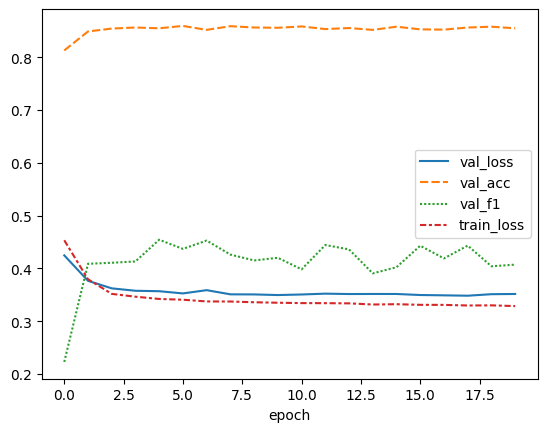

In [40]:
del metrics["step"]

# Set the epoch column as the index, for easier plotting
metrics.set_index("epoch", inplace = True)

# Display the first few rows of the metrics table, excluding any columns with all NaN values
display(metrics.dropna(axis = 1, how = "all").head())

# Create a line plot of the training metrics using Seaborn
sns.lineplot(data = metrics)

In [47]:
y_pred_stacked = torch.cat(
    trainer.predict(model = lit_clf_nn_model , dataloaders = bank_customer_churn_dm.val_dataloader())
)

y_pred_stacked[:10]

/home/jithish/Documents/pytorch-lightning-course/venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 250/250 [00:00<00:00, 853.34it/s]


tensor([[-2.6937],
        [-1.8471],
        [-2.7366],
        [-1.7298],
        [-1.6048],
        [ 6.5424],
        [-3.2221],
        [-2.6624],
        [-3.2221],
        [-3.1927]])

In [48]:
y_pred = torch.round(torch.sigmoid(y_pred_stacked))

y_pred[:10]

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.]])

In [54]:
y_true = torch.stack(labels)

y_true[:10]

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.]])

In [55]:
labels = []

for data, label in bank_customer_churn_dm.val_dataloader():
    labels.extend(label)

In [56]:
from torchmetrics.classification import BinaryAccuracy
from torchmetrics import Recall, Precision, F1Score

acc = BinaryAccuracy()
prec = Precision(task = 'binary')
recall = Recall(task = 'binary')
f1 = F1Score(task = 'binary')

print("Accuracy_score :", round(acc(y_pred, y_true).item(),3))
print("Precision_score :", round(prec(y_pred,y_true).item(),3))
print("Recall_score :" , round(recall(y_pred,y_true).item(),3))
print("F1_score :" , round(f1(y_pred,y_true).item(),3))
labels = []

for data, label in bank_customer_churn_dm.val_dataloader():
    labels.extend(label)

Accuracy_score : 0.859
Precision_score : 0.752
Recall_score : 0.499
F1_score : 0.6
